In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import rand, randn, choice, permutation
from scipy.linalg import hadamard

import torch
import torch.nn.functional as F

import tensorly as tl
from tensorly import decomposition
from tensorly.decomposition import parafac
from scipy import linalg

In [3]:
## Defining Measurement Matrices ##

## Returns gaussian mx(unweighted) of dimensionn m*N
def gaussian_mx(m,N): 
    A = np.random.normal(0.0, 1.0, [m, N])
    return A

def hadamard_mx(m,N):
    A = hadamard(N)
    l = permutation(np.range(N))
    return A[l[:m],:]

In [4]:
def vectorize_tl(X): ##Vectorisation for tensors
    x=X.numpy()
    x=x.reshape(-1)
    return x

def vectorize_np(X):  ##Vecorisation for numpy arrays
    x=X
    x=x.reshape(-1)
    return x

In [5]:
## Thresholding operators #########

def sparse_vect(x,s): ## s-sparse approximation
    
    x_1 = np.abs(x)
    index = np.flip(np.argsort(x_1))[:s]
    l = np.zeros(np.shape(x)[0])
    l[index] = x[index]

    return l

def sparse_vect_random(x,s):  ##Randomy selects indices to sparsify
    
    index = np.random.choice(np.shape(x)[0], s, replace=False)
    l = np.zeros(np.shape(x)[0])
    l[index] = x[index]
    
    return l

def random_low_rank_HOSVD(n,r,eps = 0.1):
    C=np.random.normal(0,1,size=r)+eps
    C=tl.tensor(C)
    C.shape
    X=C

    U=[]
    for i in range(len(n)):
        M=np.random.normal(0,1,size=(n[i],n[i]))+eps
        u,sigma,v=np.linalg.svd(M)
        U.append(u[:,0:r[i]])

    for i in range(len(n)):
        X=tl.tenalg.mode_dot(X,U[i],i)
    return X

def random_low_rank_CP(n,r,eps = 0.1):   #### CP Rank r
    #torch.manual_seed(0)
    #np.random.seed(0)
    
    L = []
    for i in range(0,len(n)):
        C=np.random.normal(0,1,size=(n[i],r))+eps
        L = L + [C]
    
    X = np.zeros(n)
    for i in range(r):
        U_r = np.array(L[0])[:,i]
        for j in range(1, len(n)):
            prod = np.array(L[j])[:,i]
            U_r = np.multiply.outer(U_r,prod)
        X = X + U_r
        
    C=tl.tensor(X) #Changing data frame to tensor
    C.shape
    return C

def HOSVD_rank_app(tensor,r): ## HOSVD rank-r approximation
    
    core, factors = tl.decomposition.tucker(tensor.numpy(), r) #Decomposition function is used 
    answer = torch.tensor(tl.tucker_to_tensor([core, factors]))
    
    return answer

def CP_rank_app(tensor,r):  ## CP rank-r approximation
    
    factors = parafac(tl.tensor(tensor), rank=r)
    answer = tl.cp_to_tensor(factors)
    
    return answer

In [6]:
def TIHT_CP(AA,yy,X,r,lamda = 1, itr = 100): 
    
    n = np.shape(X)
    X_ravel = np.ravel(X)
    
    error = np.zeros(itr)
    
    vXX = torch.randn(n)*0 ##Random Initialisation

    for j in range(itr):
    
        WW = np.array(vectorize_np(vXX)) + lamda*np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize_np(vXX)))))
        WW = torch.reshape(torch.tensor(WW), n)
        vXX = CP_rank_app(WW,r)
        error[j] = np.linalg.norm(vectorize_np(vXX)- X_ravel)/np.linalg.norm(X_ravel)
        
    return vXX, error

In [7]:
def TIHT_HOSVD(AA,yy,X,r,lamda = 1, itr = 100): 
    
    n = np.shape(X)
    X_ravel = np.ravel(X)
    
    error = np.zeros(itr)
    
    vXX = torch.randn(n)*0

    for j in range(itr):
    
        WW = np.array(vectorize_tl(vXX)) + lamda* np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize_tl(vXX)))))
        WW = torch.reshape(torch.tensor(WW), n)
        vXX = HOSVD_rank_app(WW,r)
        error[j] = np.linalg.norm(vectorize_tl(vXX)- X_ravel)/np.linalg.norm(X_ravel)
        
    return vXX, error

In [8]:
def KZIHT(A,b,x,s,gamma=1,itr=100): ## Selecting rows with replacement, gamma-step size for Kaczmarz
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    y = np.zeros(np.shape(x)[0])
    
    for k in range(itr): # Outer iteration for IHT updates
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            t = np.random.randint(m)
            a = A[t,:]
            y = y + gamma*(b[t] - a@y)*a/(np.linalg.norm(a)**2)
                           
        y = sparse_vect(y,s)
        error[k] = np.linalg.norm(y-x)/np.linalg.norm(x)
                             
    return y,error

In [9]:
def KZIHT_RR(A,b,x,s,gamma=1,itr=100): ## Selecting rows with replacement, gamma-step size for Kaczmarz
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    y= np.zeros(np.shape(x)[0])
    
    for k in range(itr): # Outer iteration for IHT updates
        
        t = permutation(np.arange(m))
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                           
        y = sparse_vect(y,s)
        error[k] = np.linalg.norm(y-x)/np.linalg.norm(x)
        
    return y,error

In [10]:
def KZIHT_HOSVD(A,b,X,n,r,gamma = 1, itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])    
    
    for k in range(itr): # Outer iteration for IHT updates
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            t = np.random.randint(m)
            a = A[t,:]
            y = y + gamma*(b[t] - a@y)*a/(np.linalg.norm(a)**2)
                           
        WW = torch.reshape(torch.tensor(y), n)
        y = vectorize_tl(HOSVD_rank_app(WW,r))
        error[k] = np.linalg.norm(y-x)/np.linalg.norm(x)
                             
    return y,error

In [11]:
def KZPT_HOSVD_RR(A,b,X,n,r, period = 1,gamma = 1, itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])    
    t = permutation(np.arange(m))
            
    for k in range(itr): # Outer iteration for IHT updates
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                                     
            if (j+1)%period == 0:
                WW = torch.reshape(torch.tensor(y), n)
                y = vectorize_tl(HOSVD_rank_app(WW,r))
                
        error[k] = np.linalg.norm(vectorize_np(y)-x)/np.linalg.norm(x)
                             
    return y,error

In [12]:
def KZIHT_HOSVD_RR(A,b,X,n,r,gamma = 1, itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])    
            
    for k in range(itr): # Outer iteration for IHT updates
        
        t = permutation(np.arange(m))
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                                     
        WW = torch.reshape(torch.tensor(y), n)
        y = vectorize_tl(HOSVD_rank_app(WW,r))
        error[k] = np.linalg.norm(vectorize_np(y)-x)/np.linalg.norm(x)
                             
    return y,error


In [13]:
def KZIHT_HOSVD_DET(A,b,X,n,r,gamma = 1, itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])    
            
    for k in range(itr): # Outer iteration for IHT updates
        
        t = np.arange(m)
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                                     
        WW = torch.reshape(torch.tensor(y), n)
        y = vectorize_tl(HOSVD_rank_app(WW,r))
        error[k] = np.linalg.norm(vectorize_np(y)-x)/np.linalg.norm(x)
                             
    return y,error

In [14]:
def row_normalised_mx(A,b):
    B = np.zeros(np.shape(A))
    c = np.zeros(np.shape(b))
    for i in range(np.shape(A)[0]):
        B[i,:] = A[i,:]/np.linalg.norm(A[i,:])
        c[i] = b[i]/np.linalg.norm(A[i,:])
    return B,c

In [15]:
"""
n = 1000
n_dim = [10,10,10]
r = [2,2,2]
itr = 250
m = 300

A_1 = np.random.normal(0.0,1.0,(n_dim[0],m))
A_2 = np.random.normal(0.0,1.0,(n_dim[1],m))
A_3 = np.random.normal(0.0,1.0,(n_dim[2],m))
A_4 = linalg.khatri_rao(A_1,linalg.khatri_rao(A_2,A_3))
A = A_4.T
#A = np.random.normal(0,1,(m,n))

X = random_low_rank_HOSVD(n_dim,r)
x = vectorize_np(X)

b = A@x
A_1,b_1 = row_normalised_mx(A,b)
"""

#np.save('x_2.npy', x)
#np.save('a_1_2.npy',A_1)
#np.save('a_2_2.npy',A_2)
#np.save('a_3_2.npy',A_3)
#np.save('a_4_2.npy',A_4)

n = 1000
n_dim = [10,10,10]
r = [2,2,2]
itr = 250
m = 300

A_4 = np.load('a_4_2.npy')
A = A_4.T

x = np.load('x_2.npy')
X = np.reshape(x,(10,10,10))

b = A@x
A_1,b_1 = row_normalised_mx(A,b)


In [16]:
y_IHT,error_IHT = TIHT_HOSVD(A,b,X,r,lamda=1/m,itr = 250)
y_IHT_2,error_IHT_2 = TIHT_HOSVD(A_1,b_1,X,r,lamda= n/m,itr = 250)
y_KZIHT, error_KZIHT = KZIHT_HOSVD_RR(A,b,X,n,r,gamma = n/m, itr = 250)

/Users/shambhavi/opt/anaconda3/lib/python3.9/site-packages/tensorly/backend/core.py:712: RuntimeWarning: overflow encountered in square
  return self.sqrt(self.sum(self.abs(tensor) ** 2, axis=axis))
/Users/shambhavi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/shambhavi/opt/anaconda3/lib/python3.9/site-packages/tensorly/decomposition/_tucker.py:200: RuntimeWarning: invalid value encountered in double_scalars
  rec_error = sqrt(abs(norm_tensor**2 - tl.norm(core, 2) ** 2)) / norm_tensor


In [17]:
error_IHT

array([1.98156002e+000, 1.38823001e+001, 1.76147019e+002, 2.68263676e+003,
       4.29436829e+004, 6.93289074e+005, 1.14149332e+007, 1.88879899e+008,
       3.12954391e+009, 5.18776678e+010, 8.60107056e+011, 1.42610159e+013,
       2.36459974e+014, 3.92074046e+015, 6.50099332e+016, 1.07793298e+018,
       1.78732673e+019, 2.96357685e+020, 4.91392422e+021, 8.14780680e+022,
       1.35099267e+024, 2.24008895e+025, 3.71430476e+026, 6.15871074e+027,
       1.02117948e+029, 1.69322374e+030, 2.80754432e+031, 4.65520588e+032,
       7.71882446e+033, 1.27986286e+035, 2.12214819e+036, 3.51874649e+037,
       5.83445441e+038, 9.67414343e+039, 1.60407546e+041, 2.65972702e+042,
       4.41010913e+043, 7.31242809e+044, 1.21247803e+046, 2.01041701e+047,
       3.33348437e+048, 5.52727018e+049, 9.16479945e+050, 1.51962083e+052,
       2.51969230e+053, 4.17791674e+054, 6.92742850e+055, 1.14864103e+057,
       1.90456849e+058, 3.15797630e+059, 5.23625922e+060, 8.68227245e+061,
       1.43961274e+063, 2

In [18]:
error_IHT_2

array([1.08426574e+000, 2.62519662e+000, 7.66563220e+000, 2.51466640e+001,
       8.76526991e+001, 3.19210438e+002, 1.21739919e+003, 4.85891885e+003,
       2.01506607e+004, 8.58949712e+004, 3.73669338e+005, 1.65385221e+006,
       7.43278606e+006, 3.38533416e+007, 1.55949961e+008, 7.25366107e+008,
       3.40311373e+009, 1.62742201e+010, 8.14651122e+010, 4.09227672e+011,
       2.05623999e+012, 1.03323630e+013, 5.19197616e+013, 2.60898095e+014,
       1.31103189e+015, 6.58808075e+015, 3.31060377e+016, 1.66363322e+017,
       8.36006416e+017, 4.20109920e+018, 2.11111829e+019, 1.06086904e+020,
       5.33107628e+020, 2.67894869e+021, 1.34621215e+022, 6.76498076e+022,
       3.39950758e+023, 1.70830370e+024, 8.58456127e+024, 4.31387468e+025,
       2.16778678e+026, 1.08935534e+027, 5.47417869e+027, 2.75085686e+028,
       1.38235945e+029, 6.94656937e+029, 3.49075518e+030, 1.75417281e+031,
       8.81498872e+031, 4.42966383e+032, 2.22599277e+033, 1.11859566e+034,
       5.62111067e+034, 2

In [19]:
error_KZIHT

array([9.79001742e-01, 7.86764276e-01, 5.20471392e-01, 3.81938782e-01,
       2.99941470e-01, 2.33358393e-01, 1.74094238e-01, 1.33628331e-01,
       1.05582637e-01, 8.53802652e-02, 6.77348969e-02, 5.28123693e-02,
       4.16300214e-02, 3.32799336e-02, 2.67291372e-02, 2.13988408e-02,
       1.63488416e-02, 1.27076352e-02, 1.06199675e-02, 8.30077064e-03,
       6.86996033e-03, 5.60457413e-03, 4.67831097e-03, 3.71923990e-03,
       3.15975410e-03, 2.53614453e-03, 2.06393994e-03, 1.73797778e-03,
       1.46420907e-03, 1.20117780e-03, 9.89304452e-04, 7.99823379e-04,
       6.79717943e-04, 5.40821542e-04, 4.50257203e-04, 3.63264214e-04,
       2.98895028e-04, 2.45621174e-04, 1.98001040e-04, 1.59471797e-04,
       1.35948877e-04, 1.15192246e-04, 9.61224163e-05, 7.85180532e-05,
       6.26914066e-05, 5.01692115e-05, 4.11621630e-05, 3.35530585e-05,
       2.82695308e-05, 2.33020670e-05, 1.94837727e-05, 1.64301315e-05,
       1.32282534e-05, 1.09067245e-05, 8.64190676e-06, 7.23567920e-06,
      

In [20]:
#######################################################
######## Analysing this Step-wise #####################
#######################################################

### First 5 iterations of IHT

vXX = torch.randn(n)*0
IHT_X = []
G_IHT_X = []
lamda = 1/m

for j in range(5):
    
    WW = np.array(vectorize_tl(vXX)) + lamda* np.matmul(A.T, (b - np.matmul(A, np.array(vectorize_tl(vXX)))))  
    WW = torch.reshape(torch.tensor(WW), n_dim)
    G_IHT_X = G_IHT_X + [WW]
    
    print("Gradient  :",np.linalg.norm(WW-X)/np.linalg.norm(X))
        
    vXX = HOSVD_rank_app(WW,r)
    IHT_X = IHT_X + [vXX]

    print("Threshold :",np.linalg.norm(vXX-X)/np.linalg.norm(X))


Gradient  : 3.0205982183744244
Threshold : 1.9815600153184483
Gradient  : 16.895402588441346
Threshold : 13.882300104980517
Gradient  : 185.37189410096667
Threshold : 176.14701934565366
Gradient  : 2739.9551527193976
Threshold : 2682.636755963114
Gradient  : 43605.15220675845
Threshold : 42943.68293436173


In [21]:
### First 5 iterations of IHT (w/ normalised rows)

vXX = torch.randn(n)*0
IHTN_X = []
G_IHTN_X = []
lamda = n/m

for j in range(5):
    
    WW = np.array(vectorize_tl(vXX)) + lamda* np.matmul(A.T, (b - np.matmul(A, np.array(vectorize_tl(vXX)))))  
    WW = torch.reshape(torch.tensor(WW), n_dim)
    
    G_IHTN_X = G_IHTN_X + [WW]
    print("Gradient  :",np.linalg.norm(WW-X)/np.linalg.norm(X))
    
    vXX = HOSVD_rank_app(WW,r)
    IHTN_X = IHTN_X + [vXX]

    print("Threshold :",np.linalg.norm(vXX-X)/np.linalg.norm(X))

Gradient  : 3271.1885426790395
Threshold : 2197.0212086718234
Gradient  : 20868945.092593253
Threshold : 17222355.155240193
Gradient  : 234099899057.4466
Threshold : 223499085446.92337
Gradient  : 3596710766103190.0
Threshold : 3529505419894787.5
Gradient  : 5.971158591074346e+19
Threshold : 5.899360312780203e+19


In [22]:
y = np.zeros(np.shape(x)[0]) 
KZIHT_X = []
gamma = n/m
G_KZIHT_X = []

t = permutation(np.arange(m))
            
for k in range(5): # Outer iteration for IHT updates
        
    for j in range(m): #Inner iteration for Kaczmarz updates
            
        a = A[t[j],:]
        y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                        
    WW = torch.reshape(torch.tensor(y), n_dim)
    
    G_KZIHT_X = G_KZIHT_X + [WW]
    print("Gradient  :",np.linalg.norm(WW-X)/np.linalg.norm(X))
    
    KZIHT_X = KZIHT_X + [y]
    y = vectorize_tl(HOSVD_rank_app(WW,r))
    
    print("Threshold :",np.linalg.norm(y-x)/np.linalg.norm(X))

Gradient  : 2.079018616210106
Threshold : 0.824546054290105
Gradient  : 1.709240471690849
Threshold : 0.8671062359763572
Gradient  : 1.8216636723407886
Threshold : 0.6421821875780503
Gradient  : 1.1540684765526654
Threshold : 0.3707255706726652
Gradient  : 0.5831063662904141
Threshold : 0.24550212764076249


In [23]:
###########################################################
############### Angle of descent for the iterates ######### 
###########################################################

angles_IHT = []
angles_KZIHT = []

m = np.shape(A)[0]

n = 1000
n_dim = np.shape(X)
x = np.ravel(X)

gamma = n/m
lamda = 1/m
    
y = np.zeros(np.shape(x)[0])    
t = permutation(np.arange(m))
            
for k in range(10): # Outer iteration for IHT updates
    
    y_prev = y - x    ## previous iteration
        
    for j in range(m): #Inner iteration for Kaczmarz updates
            
        a = A[t[j],:]
        y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
    
    u = y - x         ## the one that is thresholded                      
    WW = torch.reshape(torch.tensor(y), n_dim)
    y = vectorize_tl(HOSVD_rank_app(WW,r))
    v = y - x         ## post thresholding 
    
    angle = u.T@v/(np.linalg.norm(v)*np.linalg.norm(y_prev))
    angles_KZIHT = angles_KZIHT + [angle]
    

X_ravel = x
    
vXX = torch.randn(n)*0

for j in range(10):
    
    y_prev = (vectorize_tl(vXX)) - x
    WW = np.array(vectorize_tl(vXX)) + lamda* np.matmul(A.T, (b - np.matmul(A, np.array(vectorize_tl(vXX)))))
    u = WW - x  
    WW = torch.reshape(torch.tensor(WW), n_dim)
    vXX = HOSVD_rank_app(WW,r)
    v = (vectorize_tl(vXX)) - x
    
    angle = u.T@v/(np.linalg.norm(v)*np.linalg.norm(y_prev))
    angles_IHT = angles_IHT + [angle]

In [24]:
angles_IHT

[1.8107310223954671,
 7.002713613857714,
 12.688562687716198,
 15.229608311107196,
 16.008008624938203,
 16.14414596507773,
 16.464896962318424,
 16.54673714994655,
 16.568962221666833,
 16.576750267475575]

In [25]:
angles_KZIHT

[0.7976856835441817,
 0.7350741104027196,
 0.7938547281516976,
 0.747647518954293,
 0.6561389160082572,
 0.8203363871428586,
 0.6554139703521475,
 0.7033925983467774,
 0.6198084303178658,
 0.661537618604846]

In [26]:
######## Analysing Angles ################
######## Coherence between A (measurement mx) and signal x #########

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(x))/(np.linalg.norm(A[i,:])*np.linalg.norm(x))
    #print(ang)
    ang_1 = ang_1 + [ang]

In [27]:
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

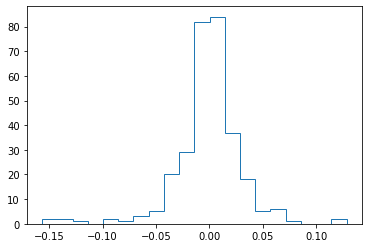

In [28]:
plt.stairs(hist, bins)

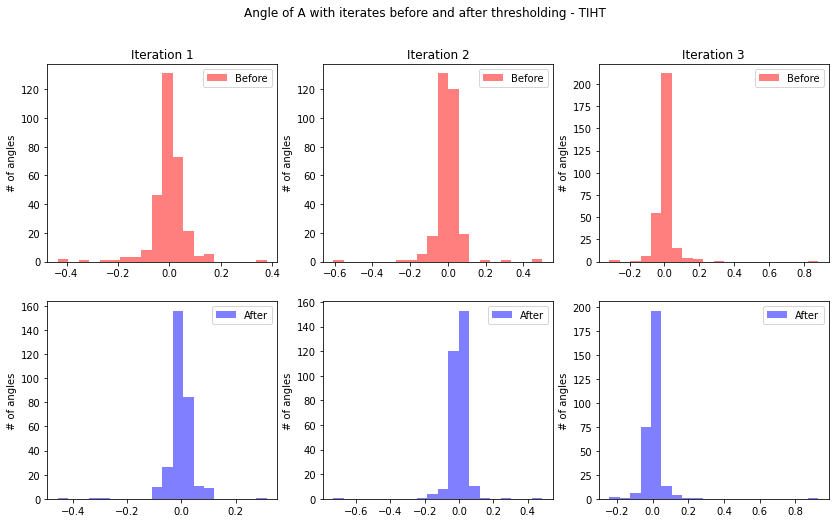

In [29]:
############### Angle of the iterates ######################## 

fig, axs = plt.subplots(2, 3)

fig.set_figheight(8)
fig.set_figwidth(14)

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(G_IHT_X[0]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(G_IHT_X[0]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[0, 0].hist(ang_1, bins, alpha = 0.5, color = 'r',label = "Before")
axs[0, 0].set_title('Iteration 1')
axs[0, 0].legend(loc="upper right")

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(IHT_X[0]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(IHT_X[0]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[1, 0].hist(ang_1, bins, alpha = 0.5, color = 'b', label = "After")
axs[1, 0].legend(loc="upper right")
#axs[1, 0].set_title('Iteration 1')


ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(G_IHT_X[1]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(G_IHT_X[1]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[0, 1].hist(ang_1, bins, alpha = 0.5, color = 'r',label = "Before")
axs[0, 1].set_title('Iteration 2')
axs[0, 1].legend(loc="upper right")

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(IHT_X[1]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(IHT_X[1]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[1, 1].hist(ang_1, bins, alpha = 0.5, color = 'b',label = "After")
#axs[1, 1].set_title('Iteration 2')
axs[1, 1].legend(loc="upper right")

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(G_IHT_X[2]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(G_IHT_X[2]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[0, 2].hist(ang_1, bins, alpha = 0.5, color = 'r', label = "Before")
axs[0, 2].set_title('Iteration 3')
axs[0, 2].legend(loc="upper right")

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(IHT_X[2]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(IHT_X[2]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[1, 2].hist(ang_1, bins, alpha = 0.5, color = 'b',label = "After")
#axs[1, 2].set_title('Iteration 3')
axs[1, 2].legend(loc="upper right")

for ax in axs.flat:
    ax.set( ylabel='# of angles')

fig.suptitle("Angle of A with iterates before and after thresholding - TIHT")
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
    #ax.label_outer()

plt.savefig('hist_IHT.png')

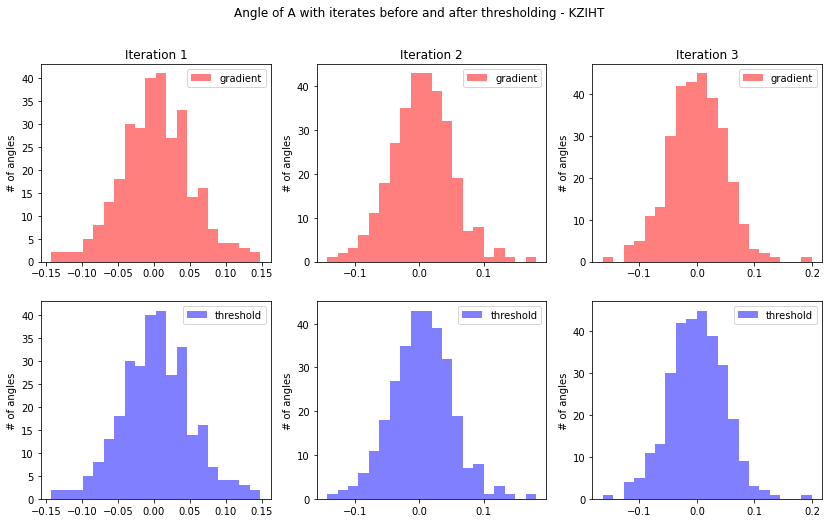

In [30]:
############### Angle of the iterates ######################## 

fig, axs = plt.subplots(2, 3)

fig.set_figheight(8)
fig.set_figwidth(14)

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(G_KZIHT_X[0]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(G_KZIHT_X[0]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[0, 0].hist(ang_1, bins, alpha = 0.5, color = 'r',label = "gradient")
axs[0, 0].set_title('Iteration 1')
axs[0, 0].legend(loc="upper right")

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(KZIHT_X[0]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(KZIHT_X[0]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[1, 0].hist(ang_1, bins, alpha = 0.5, color = 'b',label = "threshold")
axs[1, 0].legend(loc="upper right")
#axs[1, 0].set_title('Iteration 1')


ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(G_KZIHT_X[1]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(G_KZIHT_X[1]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[0, 1].hist(ang_1, bins, alpha = 0.5, color = 'r',label = "gradient")
axs[0, 1].set_title('Iteration 2')
axs[0, 1].legend(loc="upper right")

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(KZIHT_X[1]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(KZIHT_X[1]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[1, 1].hist(ang_1, bins, alpha = 0.5, color = 'b',label = "threshold")
#axs[1, 1].set_title('Iteration 2')
axs[1, 1].legend(loc="upper right")

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(G_KZIHT_X[2]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(G_KZIHT_X[2]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[0, 2].hist(ang_1, bins, alpha = 0.5, color = 'r',label = "gradient")
axs[0, 2].set_title('Iteration 3')
axs[0, 2].legend(loc="upper right")

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(KZIHT_X[2]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(KZIHT_X[2]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[1, 2].hist(ang_1, bins, alpha = 0.5, color = 'b',label = "threshold")
#axs[1, 2].set_title('Iteration 3')
axs[1, 2].legend(loc="upper right")

for ax in axs.flat:
    ax.set( ylabel='# of angles')
    
fig.suptitle("Angle of A with iterates before and after thresholding - KZIHT")
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
    #ax.label_outer()

plt.savefig('hist_KZIHT.png')

In [31]:
##################################################################
###### Randomised Average Kaczmarz ##############################
#################################################################

### Functions defined to drop high and low values from an array

def index_coherent(a, number = 5):

    a_abs = np.abs(a)
    res = sorted(range(len(a_abs)), key = lambda sub: a_abs[sub])[-number:]
    return res

def TIHT_HOSVD_incoh(AA,yy,X,r,lamda = 1, itr = 100, num = 2): 
    
    n = np.shape(X)
    X_ravel = np.ravel(X)
    
    error = np.zeros(itr)
    
    vXX = torch.randn(n)*0

    for j in range(itr):
        
        ang_1 = []
        
        for i in range(300):
            ang = AA[i,:]@(np.ravel(vectorize_tl(vXX)-x)/(np.linalg.norm(AA[i,:])*np.linalg.norm(vectorize_tl(vXX)-x)))
            ang_1 = ang_1 + [ang]
                           
        remove_row = index_coherent(np.abs(ang_1), number = num)
        A_1 = np.delete(AA,remove_row,axis = 0)
        y_1 = np.delete(yy,remove_row,axis = 0)
    
        WW = np.array(vectorize_tl(vXX)) + (m/(m-num))*lamda* np.matmul(A_1.T, (y_1 - np.matmul(A_1, np.array(vectorize_tl(vXX)))))
        WW = torch.reshape(torch.tensor(WW), n)
        vXX = HOSVD_rank_app(WW,r)
        error[j] = np.linalg.norm(vectorize_tl(vXX)- X_ravel)/np.linalg.norm(X_ravel)
          
    return vXX, error

def TIHT_HOSVD_adap(AA,yy,X,r,lamda = 1, itr = 100, num_max = 2, incoh_th = 0.1):
    
    n = np.shape(X)
    X_ravel = np.ravel(X)
    
    error = np.zeros(itr)
    
    vXX = torch.randn(n)*0

    for j in range(itr):
        
        ang_1 = []
        ele = 0
        
        for i in range(300):
            ang = AA[i,:]@(np.ravel(vectorize_tl(vXX)-x)/(np.linalg.norm(AA[i,:])*np.linalg.norm(vectorize_tl(vXX)-x)))
            ang_1 = ang_1 + [ang]
            if np.abs(ang) > incoh_th:
                ele = ele + 1
            
        num_1 = min(ele,num_max)
        #print(num_1)
        
        remove_row = index_coherent(np.abs(ang_1), number = num_1)
        
        A_1 = np.delete(AA,remove_row,axis = 0)
        y_1 = np.delete(yy,remove_row,axis = 0)
    
        WW = np.array(vectorize_tl(vXX)) + (m/(m-num_1))*lamda* np.matmul(A_1.T, (y_1 - np.matmul(A_1, np.array(vectorize_tl(vXX)))))
        WW = torch.reshape(torch.tensor(WW), n)
        vXX = HOSVD_rank_app(WW,r)
        error[j] = np.linalg.norm(vectorize_tl(vXX)- X_ravel)/np.linalg.norm(X_ravel)
          
    return vXX, error

In [32]:
y_IHT,error_IHT = TIHT_HOSVD(A,b,X,r,lamda=1/m,itr = 250)

In [33]:
error_IHT

array([1.98156002e+000, 1.38823001e+001, 1.76147019e+002, 2.68263676e+003,
       4.29436829e+004, 6.93289074e+005, 1.14149332e+007, 1.88879899e+008,
       3.12954391e+009, 5.18776678e+010, 8.60107056e+011, 1.42610159e+013,
       2.36459974e+014, 3.92074046e+015, 6.50099332e+016, 1.07793298e+018,
       1.78732673e+019, 2.96357685e+020, 4.91392422e+021, 8.14780680e+022,
       1.35099267e+024, 2.24008895e+025, 3.71430476e+026, 6.15871074e+027,
       1.02117948e+029, 1.69322374e+030, 2.80754432e+031, 4.65520588e+032,
       7.71882446e+033, 1.27986286e+035, 2.12214819e+036, 3.51874649e+037,
       5.83445441e+038, 9.67414343e+039, 1.60407546e+041, 2.65972702e+042,
       4.41010913e+043, 7.31242809e+044, 1.21247803e+046, 2.01041701e+047,
       3.33348437e+048, 5.52727018e+049, 9.16479945e+050, 1.51962083e+052,
       2.51969230e+053, 4.17791674e+054, 6.92742850e+055, 1.14864103e+057,
       1.90456849e+058, 3.15797630e+059, 5.23625922e+060, 8.68227245e+061,
       1.43961274e+063, 2

In [34]:
y_IHT_incoh,error_IHT_incoh = TIHT_HOSVD_incoh(A,b,X,r,lamda=1/m,itr = 250,num = 20)

In [35]:
error_IHT_incoh

array([1.22578626e+00, 1.88127421e+00, 1.65880002e+00, 1.86802894e+00,
       2.17864149e+00, 2.88237692e+00, 2.56455752e+00, 2.66935620e+00,
       3.42283389e+00, 2.97632525e+00, 2.69095389e+00, 2.47464560e+00,
       2.28107294e+00, 2.48761249e+00, 3.93898202e+00, 4.13137883e+00,
       5.92503991e+00, 5.61615019e+00, 6.92846504e+00, 6.01345514e+00,
       6.36693198e+00, 5.37633830e+00, 4.26892363e+00, 4.59605866e+00,
       4.59467289e+00, 4.10417966e+00, 3.10628137e+00, 2.66551649e+00,
       2.31679717e+00, 2.10260503e+00, 1.88097933e+00, 1.65092374e+00,
       1.45299992e+00, 1.41547550e+00, 1.18177915e+00, 1.14930585e+00,
       9.44421783e-01, 8.46264171e-01, 9.97423485e-01, 8.39856945e-01,
       7.35923559e-01, 5.61153390e-01, 4.17814304e-01, 3.21290949e-01,
       2.63981962e-01, 2.12573487e-01, 1.77674674e-01, 1.48578959e-01,
       1.25085242e-01, 1.05356431e-01, 9.79515213e-02, 8.55735181e-02,
       6.95072842e-02, 6.02218717e-02, 5.08983198e-02, 4.59410946e-02,
      

In [36]:
y_IHT_adap,error_IHT_adap = TIHT_HOSVD_adap(A,b,X,r,lamda=1/m,itr = 250,num_max = 20,incoh_th = 0.045)

In [37]:
error_IHT_adap

array([1.22578626e+00, 1.88127421e+00, 1.65880002e+00, 1.86802894e+00,
       2.17864149e+00, 2.88237692e+00, 2.56455752e+00, 2.66935620e+00,
       3.42283389e+00, 2.97632525e+00, 2.69095389e+00, 2.47464560e+00,
       2.28107294e+00, 2.48761249e+00, 3.93898202e+00, 4.13137883e+00,
       5.92503991e+00, 5.61615019e+00, 6.92846504e+00, 6.01345514e+00,
       6.36693198e+00, 5.37633830e+00, 4.26892363e+00, 4.59605866e+00,
       4.59467289e+00, 4.10417966e+00, 3.10628137e+00, 2.66551649e+00,
       2.31679717e+00, 2.10260503e+00, 1.88097933e+00, 1.65092374e+00,
       1.45299992e+00, 1.41547550e+00, 1.18177915e+00, 1.14930585e+00,
       9.44421783e-01, 8.46264171e-01, 9.97423485e-01, 8.39856945e-01,
       7.35923559e-01, 5.61153390e-01, 4.17814304e-01, 3.21290949e-01,
       2.62900504e-01, 2.20939630e-01, 1.77585892e-01, 1.56998347e-01,
       1.26228527e-01, 1.13001549e-01, 9.51630170e-02, 8.39233496e-02,
       7.05453838e-02, 5.98580104e-02, 5.18856648e-02, 4.56221057e-02,
      

In [38]:
AA = A
yy = b
num = 20
n = np.shape(X)
X_ravel = np.ravel(X)
lamda = 1/m

num_max = 20
incoh_th = 0.045
    
error = np.zeros(itr)
error_1 = np.zeros(itr)
error_2 = np.zeros(itr)
    
vXX = torch.randn(n)*0
vXX_2 = torch.randn(n)*0
vXX_3 = torch.randn(n)*0

for j in range(105):

    ang_1 = []
    
    for i in range(300):
        ang = AA[i,:]@(np.ravel(vectorize_tl(vXX)-x)/(np.linalg.norm(AA[i,:])*np.linalg.norm(vectorize_tl(vXX)-x)))
        ang_1 = ang_1 + [ang]
                           
    remove_row = index_coherent(np.abs(ang_1), number = num)
    A_1 = np.delete(AA,remove_row,axis = 0)
    y_1 = np.delete(yy,remove_row,axis = 0)
    
    WW = np.array(vectorize_tl(vXX)) + (m/(m-num))*lamda* np.matmul(A_1.T, (y_1 - np.matmul(A_1, np.array(vectorize_tl(vXX)))))
    WW = torch.reshape(torch.tensor(WW), n)
    vXX = HOSVD_rank_app(WW,r)
    
    WW_2 = np.array(vectorize_tl(vXX_2)) + lamda* np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize_tl(vXX_2)))))
    WW_2 = torch.reshape(torch.tensor(WW_2), n)
    vXX_2 = HOSVD_rank_app(WW_2,r)
    
    ang_1 = []
    ele = 0
        
    for i in range(300):
        ang = AA[i,:]@(np.ravel(vectorize_tl(vXX_3)-x)/(np.linalg.norm(AA[i,:])*np.linalg.norm(vectorize_tl(vXX_3)-x)))
        ang_1 = ang_1 + [ang]
        if np.abs(ang) > incoh_th:
            ele = ele + 1
            
    num_1 = min(ele,num_max)
    remove_row_2 = index_coherent(np.abs(ang_1), number = num_1)
    
    A_2 = np.delete(AA,remove_row_2,axis = 0)
    y_2 = np.delete(yy,remove_row_2,axis = 0)
                
    WW_3 = np.array(vectorize_tl(vXX_3)) + (m/(m-num_1))*lamda* np.matmul(A_2.T, (y_2 - np.matmul(A_2, np.array(vectorize_tl(vXX_3)))))
    WW_3 = torch.reshape(torch.tensor(WW_3), n)
    vXX_3 = HOSVD_rank_app(WW_3,r)
    error_2[j] = np.linalg.norm(vectorize_tl(vXX_3)- X_ravel)/np.linalg.norm(X_ravel)
    
    error[j] = np.linalg.norm(vectorize_tl(vXX)- X_ravel)/np.linalg.norm(X_ravel)
    error_1[j] = np.linalg.norm(vectorize_tl(vXX_2)- X_ravel)/np.linalg.norm(X_ravel)
    error_2[j] = np.linalg.norm(vectorize_tl(vXX_3)- X_ravel)/np.linalg.norm(X_ravel)
    
    print("Fixed clipping:",error[j])
    print("normal:",error_1[j])
    print("adaptive clipping:", error_2[j])

Fixed clipping: 1.2257862585672097
normal: 1.9815600153184483
adaptive clipping: 1.2257862585672097
Fixed clipping: 1.881274207134894
normal: 13.882300104980517
adaptive clipping: 1.881274207134894
Fixed clipping: 1.65880002498789
normal: 176.14701934565366
adaptive clipping: 1.65880002498789
Fixed clipping: 1.8680289375282202
normal: 2682.636755963114
adaptive clipping: 1.8680289375282202
Fixed clipping: 2.178641492656313
normal: 42943.68293436173
adaptive clipping: 2.178641492656313
Fixed clipping: 2.882376920543902
normal: 693289.0738412134
adaptive clipping: 2.882376920543902
Fixed clipping: 2.564557522365648
normal: 11414933.16834155
adaptive clipping: 2.564557522365648
Fixed clipping: 2.6693561967205683
normal: 188879898.72028762
adaptive clipping: 2.6693561967205683
Fixed clipping: 3.4228338884033507
normal: 3129543906.3287983
adaptive clipping: 3.4228338884033507
Fixed clipping: 2.976325247049487
normal: 51877667786.31247
adaptive clipping: 2.976325247049487
Fixed clipping: 2.6

Fixed clipping: 0.0010478168896801132
normal: 6.993187706283016e+105
adaptive clipping: 0.0004691944608960988
Fixed clipping: 0.0009278570470478456
normal: 1.159544597988768e+107
adaptive clipping: 0.00041706787178534283
Fixed clipping: 0.0008502137912484606
normal: 1.922647769795926e+108
adaptive clipping: 0.00036682459716280485
Fixed clipping: 0.0007476237894743513
normal: 3.1879536613882396e+109
adaptive clipping: 0.0003419416690681267
Fixed clipping: 0.0006726893678680593
normal: 5.285964858886975e+110
adaptive clipping: 0.0003086474555674067
Fixed clipping: 0.0006249550529995862
normal: 8.764689659014844e+111
adaptive clipping: 0.0002533414262793721
Fixed clipping: 0.0005463252853839388
normal: 1.453278386625844e+113
adaptive clipping: 0.00021548962551417152
Fixed clipping: 0.00047480818052772353
normal: 2.4096895055052156e+114
adaptive clipping: 0.00019419927388112523
Fixed clipping: 0.0004292378832670254
normal: 3.995520449749119e+115
adaptive clipping: 0.00016276122956367296
Fi

In [39]:
pd.DataFrame(np.concatenate(([error],[error_2],[error_1]),axis = 0)[:,:100].T, columns = ["Fixed Clipping","Adapted Clipping","Normal"])

,Fixed Clipping,Adapted Clipping,Normal
0,1.225786,1.225786,1.981560e+00
1,1.881274,1.881274,1.388230e+01
2,1.658800,1.658800,1.761470e+02
3,1.868029,1.868029,2.682637e+03
4,2.178641,2.178641,4.294368e+04
...,...,...,...
95,0.000429,0.000163,3.995520e+115
96,0.000382,0.000144,6.624996e+116
97,0.000358,0.000132,1.098495e+118
98,0.000321,0.000117,1.821420e+119


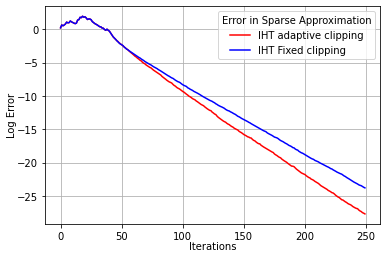

In [40]:
plt.plot(range(itr), np.log(error_IHT_adap),  label= "IHT adaptive clipping", color = 'red')

plt.plot(range(itr), np.log(error_IHT_incoh),  label= "IHT Fixed clipping", color = 'blue')

plt.legend(title="Error in Sparse Approximation")
plt.xlabel(xlabel="Iterations",labelpad = 0)
plt.ylabel(ylabel="Log Error",labelpad = 0)
plt.grid()
plt.savefig('TIHT with adaptive and incoherence clipping', dpi=300,  bbox_inches="tight")

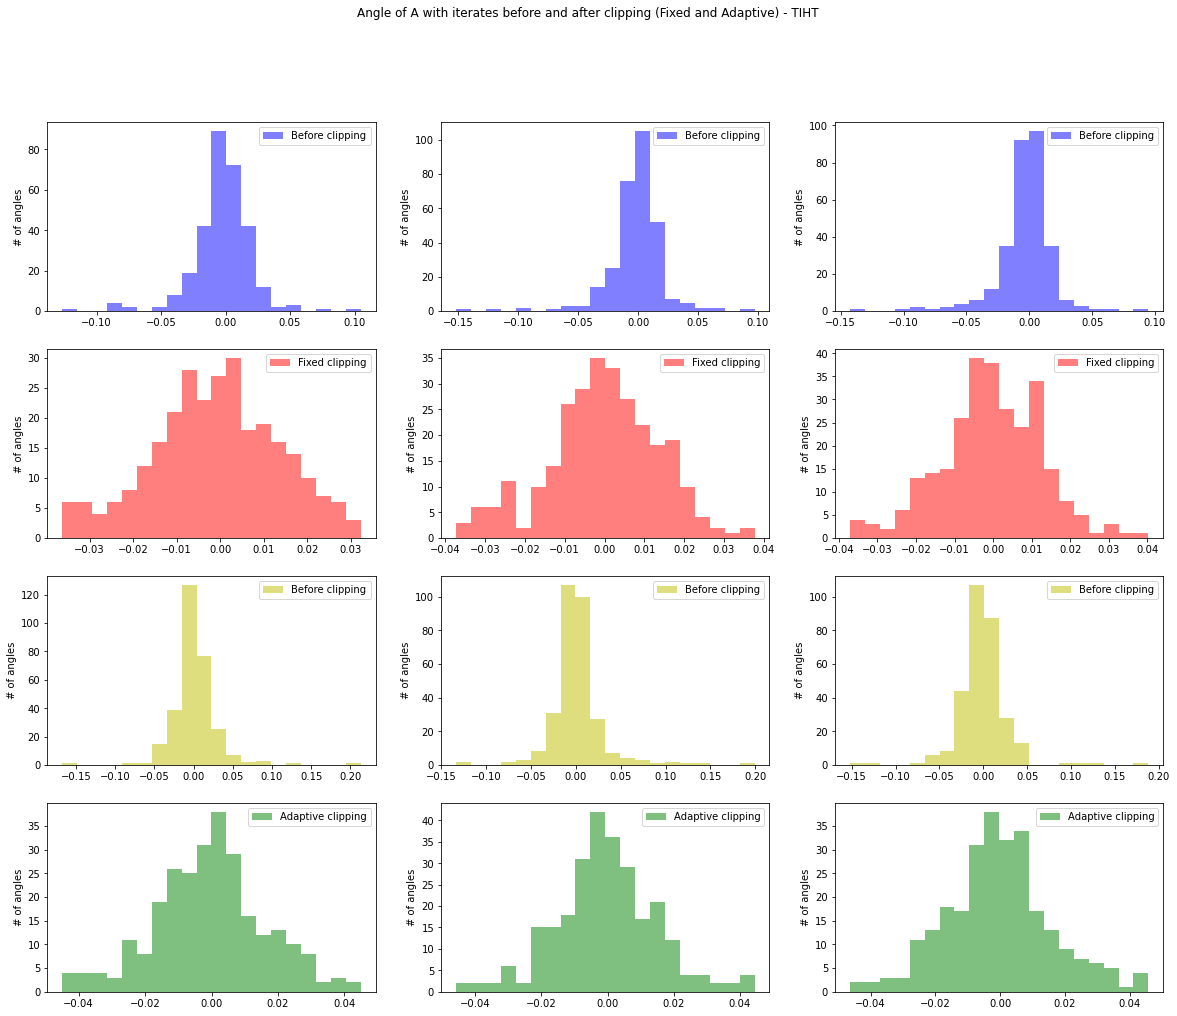

In [41]:
###############################################################
#### Understanding how the row selection works for: ###########
#### a) Incoherence clipping ##################################
#### b) Adaptive clipping #####################################

#### Iterations 100-105 
fig, axs = plt.subplots(4, 3)
fig.set_figheight(16)
fig.set_figwidth(20)

AA = A
yy = b
num = 20
n = np.shape(X)
X_ravel = np.ravel(X)
lamda = 1/m

num_max = 20
incoh_th = 0.045
    
error = np.zeros(itr)
error_1 = np.zeros(itr)
error_2 = np.zeros(itr)
    
vXX = torch.randn(n)*0
vXX_2 = torch.randn(n)*0
vXX_3 = torch.randn(n)*0

for j in range(103):

    ang_1 = []
    
    for i in range(300):
        ang = AA[i,:]@(np.ravel(vectorize_tl(vXX)-x)/(np.linalg.norm(AA[i,:])*np.linalg.norm(vectorize_tl(vXX)-x)))
        ang_1 = ang_1 + [ang]
                           
    remove_row = index_coherent(np.abs(ang_1), number = num)
    
    if j >=100:
        
        hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)
        axs[0, j-100].hist(ang_1, bins, alpha = 0.5, color = 'b',label = "Before clipping")
        #axs[1, 2].set_title('Iteration 3')
        axs[0, j-100].legend(loc="upper right")
        
        hist, bins = np.histogram(np.delete(ang_1,remove_row,axis=0), bins=20, range=None, density=None, weights=None)
        axs[1, j-100].hist(np.delete(ang_1,remove_row,axis=0), bins, alpha = 0.5, color = 'r',label = "Fixed clipping")
        axs[1, j-100].legend(loc="upper right")
        
    
    A_1 = np.delete(AA,remove_row,axis = 0)
    y_1 = np.delete(yy,remove_row,axis = 0)
    
    WW = np.array(vectorize_tl(vXX)) + (m/(m-num))*lamda* np.matmul(A_1.T, (y_1 - np.matmul(A_1, np.array(vectorize_tl(vXX)))))
    WW = torch.reshape(torch.tensor(WW), n)
    vXX = HOSVD_rank_app(WW,r)
    
    WW_2 = np.array(vectorize_tl(vXX_2)) + lamda* np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize_tl(vXX_2)))))
    WW_2 = torch.reshape(torch.tensor(WW_2), n)
    vXX_2 = HOSVD_rank_app(WW_2,r)
    
    ang_1 = []
    ele = 0
        
    for i in range(300):
        ang = AA[i,:]@(np.ravel(vectorize_tl(vXX_3)-x)/(np.linalg.norm(AA[i,:])*np.linalg.norm(vectorize_tl(vXX_3)-x)))
        ang_1 = ang_1 + [ang]
        if np.abs(ang) > incoh_th:
            ele = ele + 1
            
    num_1 = min(ele,num_max)
    remove_row_2 = index_coherent(np.abs(ang_1), number = num_1)
    
    if j >=100:
        
        hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)
        axs[2, j-100].hist(ang_1, bins, alpha = 0.5, color = 'y',label = "Before clipping")
        #axs[1, 2].set_title('Iteration 3')
        axs[2, j-100].legend(loc="upper right")
        
        hist, bins = np.histogram(np.delete(ang_1,remove_row_2,axis=0), bins=20, range=None, density=None, weights=None)
        axs[3, j-100].hist(np.delete(ang_1,remove_row,axis=0), bins, alpha = 0.5, color = 'g',label = "Adaptive clipping")
        axs[3, j-100].legend(loc="upper right")
    
    A_2 = np.delete(AA,remove_row_2,axis = 0)
    y_2 = np.delete(yy,remove_row_2,axis = 0)
                
    WW_3 = np.array(vectorize_tl(vXX_3)) + (m/(m-num_1))*lamda* np.matmul(A_2.T, (y_2 - np.matmul(A_2, np.array(vectorize_tl(vXX_3)))))
    WW_3 = torch.reshape(torch.tensor(WW_3), n)
    vXX_3 = HOSVD_rank_app(WW_3,r)
    error_2[j] = np.linalg.norm(vectorize_tl(vXX_3)- X_ravel)/np.linalg.norm(X_ravel)
    
    error[j] = np.linalg.norm(vectorize_tl(vXX)- X_ravel)/np.linalg.norm(X_ravel)
    error_1[j] = np.linalg.norm(vectorize_tl(vXX_2)- X_ravel)/np.linalg.norm(X_ravel)
    error_2[j] = np.linalg.norm(vectorize_tl(vXX_3)- X_ravel)/np.linalg.norm(X_ravel)
    
    fig.suptitle("Angle of A with iterates before and after clipping (Fixed and Adaptive) - TIHT")
    
    for ax in axs.flat:
        ax.set( ylabel='# of angles')

In [65]:
##################################################################
######### Inferring Coherence from Kaczmarz Projection ###########
##################################################################

def proj_vals(A,b,x_it):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    
    proj = []
    
    for j in range(m): #Inner iteration for Kaczmarz updates
        a = A[j,:]
        proj_val = x_it + gamma*(b[j] - a@x_it)*a/(np.linalg.norm(a)**2)
        proj = proj + [np.linalg.norm(proj_val-x_it)]
    
    return proj

In [66]:
AA = A
yy = b
num = 20
n = np.shape(X)
X_ravel = np.ravel(X)
lamda = 1/m

num_max = 20
incoh_th = 0.045
    
error = np.zeros(itr)
error_1 = np.zeros(itr)
    
vXX = torch.randn(n)*0
vXX_2 = torch.randn(n)*0
vXX_3 = torch.randn(n)*0

cols = []

for j in range(10):

    ang_1 = []
    cols = cols + ['ang '+str(j),'proj '+str(j)]
    
    for i in range(300):
        ang = AA[i,:]@(np.ravel(vectorize_tl(vXX)-x)/(np.linalg.norm(AA[i,:])*np.linalg.norm(vectorize_tl(vXX)-x)))
        ang_1 = ang_1 + [ang]
                           
    remove_row = index_coherent(np.abs(ang_1), number = num)
    
    proj = proj_vals(AA,yy,np.array(vectorize_tl(vXX)))
    
    A_1 = np.delete(AA,remove_row,axis = 0)
    y_1 = np.delete(yy,remove_row,axis = 0)
    
    WW = np.array(vectorize_tl(vXX)) + (m/(m-num))*lamda* np.matmul(A_1.T, (y_1 - np.matmul(A_1, np.array(vectorize_tl(vXX)))))
    WW = torch.reshape(torch.tensor(WW), n)
    vXX = HOSVD_rank_app(WW,r)
    
    if j == 0:    
        data = np.concatenate(([ang_1],[proj]), axis = 0).T
    
    else:
        
        data = np.concatenate((data, np.array([ang_1]).T),axis=1)
        data = np.concatenate((data, np.array([proj]).T),axis=1)
    
data = pd.DataFrame(data, columns = cols)
data.to_csv("proj_ang.csv", header = True)
    

In [67]:
#######################################################################
########## Convergence by removing high proj values ###################
#######################################################################

data

,ang 0,proj 0,ang 1,proj 1,ang 2,proj 2,ang 3,proj 3,ang 4,proj 4,ang 5,proj 5,ang 6,proj 6,ang 7,proj 7,ang 8,proj 8,ang 9,proj 9
0,-0.042547,0.308274,-0.017531,0.155702,-0.019795,0.269820,0.062872,0.755657,-0.048408,0.655196,-0.021359,0.337163,-0.007639,0.159545,-0.004658,0.086559,-0.030139,0.582923,-0.021927,0.543791
1,-0.006748,0.048891,0.002933,0.026047,0.034370,0.468496,0.002548,0.030624,0.011107,0.150335,0.021572,0.340518,0.037738,0.788126,-0.011802,0.219304,0.066012,1.276724,-0.067536,1.674918
2,-0.003309,0.023976,-0.022423,0.199151,0.001968,0.026820,0.009552,0.114803,0.005309,0.071851,-0.001991,0.031436,-0.001215,0.025378,0.017704,0.328973,-0.001226,0.023717,-0.000410,0.010162
3,0.031371,0.227302,0.024816,0.220398,0.014663,0.199872,-0.000296,0.003559,0.018977,0.256854,0.015505,0.244753,0.010865,0.226911,-0.008032,0.149239,0.055949,1.082107,0.020153,0.499790
4,0.017906,0.129736,0.011909,0.105771,0.007042,0.095995,0.018413,0.221303,0.012381,0.167571,0.008447,0.133338,0.003545,0.074028,0.024234,0.450298,-0.031409,0.607470,0.010513,0.260719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.028546,0.206832,-0.250474,2.224583,-0.003231,0.044040,-0.069048,0.829885,0.181141,2.451724,0.061036,0.963481,0.004905,0.102447,0.018843,0.350128,0.040204,0.777590,-0.025664,0.636479
296,0.046448,0.336538,-0.085055,0.755414,0.007199,0.098130,-0.067613,0.812631,-0.011137,0.150741,0.024814,0.391693,-0.100878,2.106779,0.035483,0.659331,-0.009750,0.188567,0.028181,0.698888
297,0.008742,0.063342,0.003141,0.027900,-0.009362,0.127618,-0.003756,0.045144,0.004859,0.065772,0.013564,0.214112,-0.030018,0.626901,-0.031627,0.587672,0.001412,0.027305,0.027361,0.678556
298,0.006431,0.046594,0.005875,0.052180,0.005431,0.074028,0.005900,0.070911,0.031592,0.427587,0.043106,0.680450,0.005245,0.109543,0.011879,0.220730,-0.004652,0.089981,-0.002370,0.058771


In [59]:
######################################################################################
##### Observation "high coherence" associated with large distance to projection (Why??)

def high_proj(a, number = 5):

    res = sorted(range(len(a)), key = lambda sub: a[sub])[-number:]
    return res

def TIHT_HOSVD_proj(AA,yy,X,r,lamda = 1, itr = 100, num = 2): 
    
    n = np.shape(X)
    X_ravel = np.ravel(X)
    
    error = np.zeros(itr)
    
    vXX = torch.randn(n)*0

    for j in range(itr):
        
        proj = proj_vals(AA,yy,np.array(vectorize_tl(vXX)))
                           
        remove_row = high_proj(proj, number = num)
        A_1 = np.delete(AA,remove_row,axis = 0)
        y_1 = np.delete(yy,remove_row,axis = 0)
    
        WW = np.array(vectorize_tl(vXX)) + (m/(m-num))*lamda* np.matmul(A_1.T, (y_1 - np.matmul(A_1, np.array(vectorize_tl(vXX)))))
        WW = torch.reshape(torch.tensor(WW), n)
        vXX = HOSVD_rank_app(WW,r)
        error[j] = np.linalg.norm(vectorize_tl(vXX)- X_ravel)/np.linalg.norm(X_ravel)
          
    return vXX, error

In [60]:
y_IHT_proj,error_IHT_proj = TIHT_HOSVD_proj(A,b,X,r,lamda=1/m,itr = 250,num= 20)

In [61]:
error_IHT_proj 

array([1.22578626e+00, 1.88127421e+00, 1.65880002e+00, 1.86802894e+00,
       2.17864149e+00, 2.88237692e+00, 2.56455752e+00, 2.66935620e+00,
       3.42283389e+00, 2.97632525e+00, 2.69095389e+00, 2.47464560e+00,
       2.28107294e+00, 2.48761249e+00, 3.93898202e+00, 4.13137883e+00,
       5.92503991e+00, 5.61615019e+00, 6.92846504e+00, 6.01345514e+00,
       6.36693198e+00, 5.37633830e+00, 4.26892363e+00, 4.59605866e+00,
       4.59467289e+00, 4.10417966e+00, 3.10628137e+00, 2.66551649e+00,
       2.31679717e+00, 2.10260503e+00, 1.88097933e+00, 1.65092374e+00,
       1.45299992e+00, 1.41547550e+00, 1.18177915e+00, 1.14930585e+00,
       9.44421783e-01, 8.46264171e-01, 9.97423485e-01, 8.39856945e-01,
       7.35923559e-01, 5.61153390e-01, 4.17814304e-01, 3.21290949e-01,
       2.63981962e-01, 2.12573487e-01, 1.77674674e-01, 1.48578959e-01,
       1.25085242e-01, 1.05356431e-01, 9.79515213e-02, 8.55735181e-02,
       6.95072842e-02, 6.02218717e-02, 5.08983198e-02, 4.59410946e-02,
      

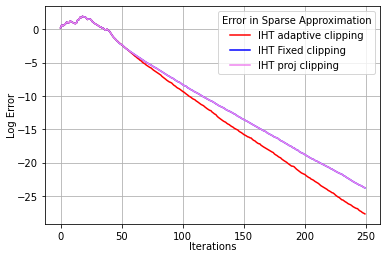

In [69]:
plt.plot(range(itr), np.log(error_IHT_adap),  label= "IHT adaptive clipping", color = 'red')

plt.plot(range(itr), np.log(error_IHT_incoh),  label= "IHT Fixed clipping", color = 'blue')

plt.plot(range(itr), np.log(error_IHT_proj),  label= "IHT proj clipping", color = 'violet')

plt.legend(title="Error in Sparse Approximation")
plt.xlabel(xlabel="Iterations",labelpad = 0)
plt.ylabel(ylabel="Log Error",labelpad = 0)
plt.grid()
plt.savefig('TIHT with adaptive and incoherence clipping', dpi=300,  bbox_inches="tight")

